# Results of ACCURE Battery Data Challenge

## Presentation and Analysis

First, we import the libraries that will be used in this notebook, and we create the function csv_to_pd, which will extract the data from the .csv files and store them in a dataframe.

*Disclaimer:* The following datasets do not include metric units associated with them. The variables will, therefore, be associated with their conventional (SI) units, such as Ampere for current, Volts for voltage, and Celsius for temperature.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def csv_to_pd(path):
    """ Stores .csv data into a Pandas dataframe and assigns the 'timestamp' column as the index """
    
    data = pd.read_csv(path, index_col=[0]) 
    data['timestamp'] = pd.to_datetime(data['timestamp']) 
    data = data.set_index('timestamp') 
    return data

## Sample Dataset 1

Dataset 1 has a total of five hundred thousand data points, which correspond to a time window between January 1st and January 17th, 2022. The measurements were taken in small timesteps, approximately every two seconds. 

The data is imported into the variable *dataset_1*. In order to determine the percentage of time that the battery spent charging, discharging and idle, the change in current over time must be analyzed. A positive current means that the system is charging, a negative current means that it is discharging, and a relatively low current means it is in idle mode. The following plot helps visualize this process.

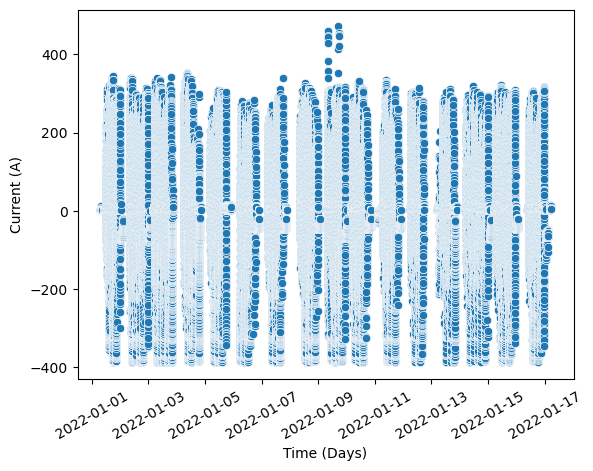

In [3]:
dataset_1 = csv_to_pd("data//sample_dataset_1.csv")

def plot_current(data):
    """ Plots the current in chronological order """
    
    sns.scatterplot(data=data, x=data.index, y="current")
    plt.ylabel("Current (A)")
    plt.xlabel("Time (Days)")
    plt.xticks(rotation=30)
    plt.show()

plot_current(dataset_1)


We want to explore the data and search for missing values, as they would affect the percentages that we are searching for. The following function will add up the amount of NA values and calculate the percentage they represent within the feature.

In [4]:
def count_na(column):
    """ Counts number of NA values and their percentage in a dataframe column """
    
    num_empty_values = column.isna().sum()
    total = len(column)
    percentage = (num_empty_values/total)*100
    return f"There are {num_empty_values} NA instances, which represent {percentage}% of the variable."

In [5]:
count_na(dataset_1["current"])

'There are 54049 NA instances, which represent 10.8098% of the variable.'

This number is very high and would clearly affect the results of the analysis. Since we are working with relatively continuous data, a proposed solution is to fill in these gaps with the average between the previous value and the next (existing) value. The function missing_current is thus created and then tested.

In [6]:
def missing_current(column)->None:
    """ Fills missing values with the average between their predecessor and successor """
    
    for i in range(1, len(column) - 1): #Every row, from the second to the penultimate 
        if pd.isna(column[i]) == True: #If the row is NA, average its predecessor and its successor
            previous = column[i-1]
            j=i+1
            next = column[j]
            while pd.isna(next) == True and j<len(column): #If its successor is also NA, try the next one
                j +=1
                next = column[j]
            column[i] = (previous + next)/2

In [7]:
missing_current(dataset_1["current"])

In [8]:
count_na(dataset_1["current"])

'There are 0 NA instances, which represent 0.0% of the variable.'

Now, the function *charging_modes* is defined, which will approximately count how many times the current has been positive, negative or remaining generally low. The counts will be added to a dictionary.

In [9]:
def charging_modes(df, threshold=5):
    """Counts how many times each of the states occur in given dataframe df, depending on threshold"""
    
    modes = {"Charging":0, "Discharging":0, "Idle":0}  #Dictionary is initialized, with each value (count) equal to 0
    for i in range(len(df)):                          #For every number in the length of the dataframe
        if df.iloc[i]["current"] > threshold:    #If current > threshold, add 1 to charging
            modes["Charging"] += 1
        elif df.iloc[i]["current"] < -threshold: #If current < -threshold, add 1 to discharging
            modes["Discharging"] += 1
        else:
            modes["Idle"] += 1
    return modes

In [10]:
modes_count_1 = charging_modes(dataset_1)

In [11]:
print(modes_count_1)

{'Charging': 248962, 'Discharging': 153105, 'Idle': 97933}


Now, we can use this dictionary to plot a pie chart and visualize which percentages they each have.

In [12]:
def plot_piechart(states: dict):
    """ Plots a pie chart with the percentages of each mode """
    
    counts = list(states.values())
    plt.pie(counts, labels=states.keys(), autopct='%1.1f%%')
    plt.show()

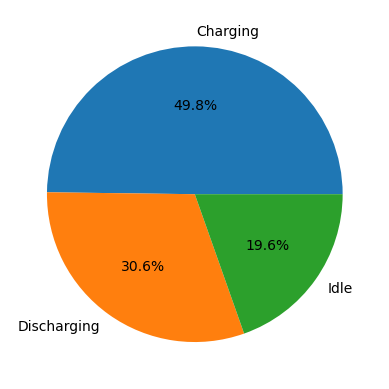

In [13]:
plot_piechart(modes_count_1)

In order to determine further characteristics of the system, the cell-specific features are shown in the graphs below.

<function matplotlib.pyplot.show(close=None, block=None)>

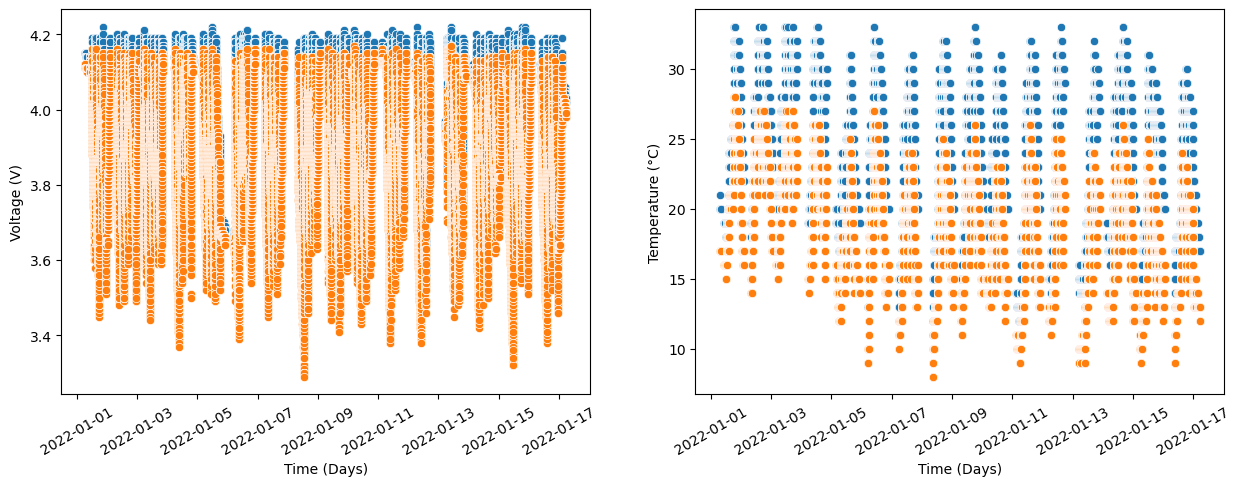

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=dataset_1, x=dataset_1.index, y="voltage_cell_max")
sns.scatterplot(data=dataset_1, x=dataset_1.index, y="voltage_cell_min")
plt.ylabel("Voltage (V)")
plt.xlabel("Time (Days)")
plt.xticks(rotation=30)

plt.subplot(1, 2, 2)
sns.scatterplot(data=dataset_1, x=dataset_1.index, y="temperature_cell_max")
sns.scatterplot(data=dataset_1, x=dataset_1.index, y="temperature_cell_min")
plt.ylabel("Temperature (°C)")
plt.xlabel("Time (Days)")
plt.xticks(rotation=30)
plt.show

We observe that the voltage ranges from ~3.3-4.2 V, and the temperature from ~8-34 °C. This profile would indicate that the type of cell chemistry might be LCO, LMO or NMC. To further reach a conclusion, the voltage of the entire system is also displayed in a plot.

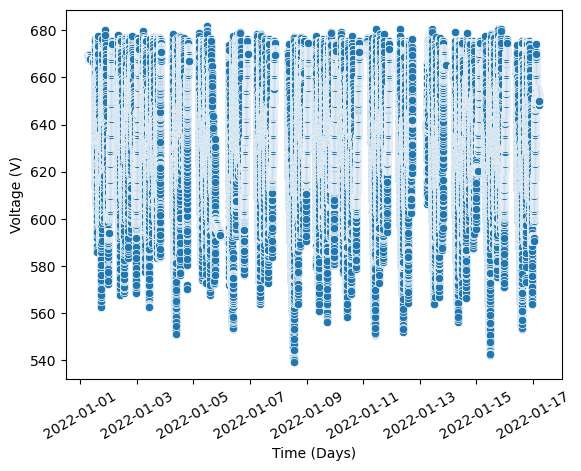

In [15]:
sns.scatterplot(data=dataset_1, x=dataset_1.index, y="voltage")
plt.ylabel("Voltage (V)")
plt.xlabel("Time (Days)")
plt.xticks(rotation=30)
plt.show()

The voltage of the system is relatively high, ranging from 540 to 680 V. This, along with the systems' high capacity of 300 Ah and the cells' capacity of 25 Ah, allows for the assumption that the cell chemistry used here corresponds to NMC, as that type is commonly used for high-power applications that require such numbers, and that NMC is the most commercially successful type of chemistry in Li-ion batteries. For instance, this battery could be used to power an electric vehicle.

Given that the capacity of each module is bigger than their individual cells, the cells must be connected in parallel, which means that:

$$Cells = \frac{Capacity_{total}}{Capacity_{cell}} = \frac{300 Ah}{25 Ah} = 12$$ 

Since the connection is parallel, the voltage remains the same for each module as it is for the single cells. In order for the voltage of the system to reach those of the figure above, the modules must be connected in series, which would sum the voltages and keep the system's capacity constant at 300 Ah. The function *number_of_cells* will divide the system's full voltage by the maximum voltage of the individual cells (could also work with the minimum), and multiply it with the number of cells per module. The average will give us an approximation for the total number of cells.

In [16]:
def number_of_cells(n, data):
    """ Outputs approximate amount of cells in the system """
    cells = n*data["voltage"] / data["voltage_cell_max"]
    return cells.mean()

In [17]:
number_of_cells(12, dataset_1)

1934.696438728436

In conclusion, there are approximately 1935 individual cells, distributed in modules of 12 cells (with 1932 being the lower multiple of 12 and a more realistic approximation).

## Sample Dataset 2

Now we move on to Dataset 2, which contains data collected for the entire month of May 2023, and with instances being measured every 5 minutes, for a total amount of 8928 instances.

The data is loaded into the variable *dataset_2* and then plotted.

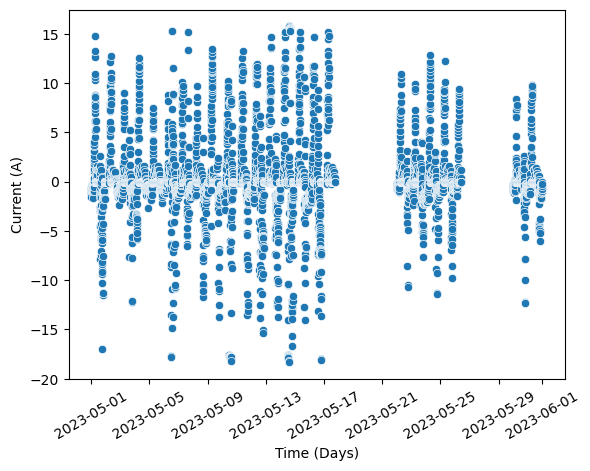

In [18]:
dataset_2 = csv_to_pd("data//sample_dataset_2.csv")

plot_current(dataset_2)

It is evident that there are two large gaps. These missing values cannot be interpolated using the *missing_current()* function created before. As there is no way of recovering that missing data, we will proceed with the analysis as it is.

In [19]:
modes_count_2 = charging_modes(dataset_2, threshold=2)
print(modes_count_2)

{'Charging': 744, 'Discharging': 570, 'Idle': 7614}


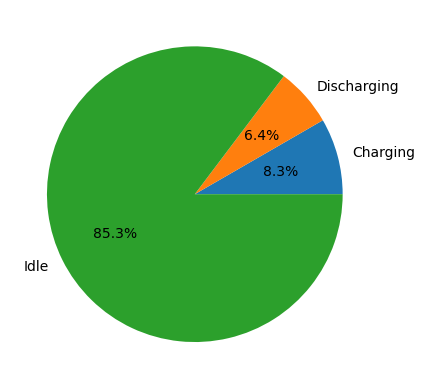

In [20]:
plot_piechart(modes_count_2)

The pie chart shows that the most predominant state is idle, which might suggest that the battery is used for storage purposes. However, due to the large amount of missing data, this cannot yet be confirmed. Hence, we will next look at the cell-specific characteristics.

<function matplotlib.pyplot.show(close=None, block=None)>

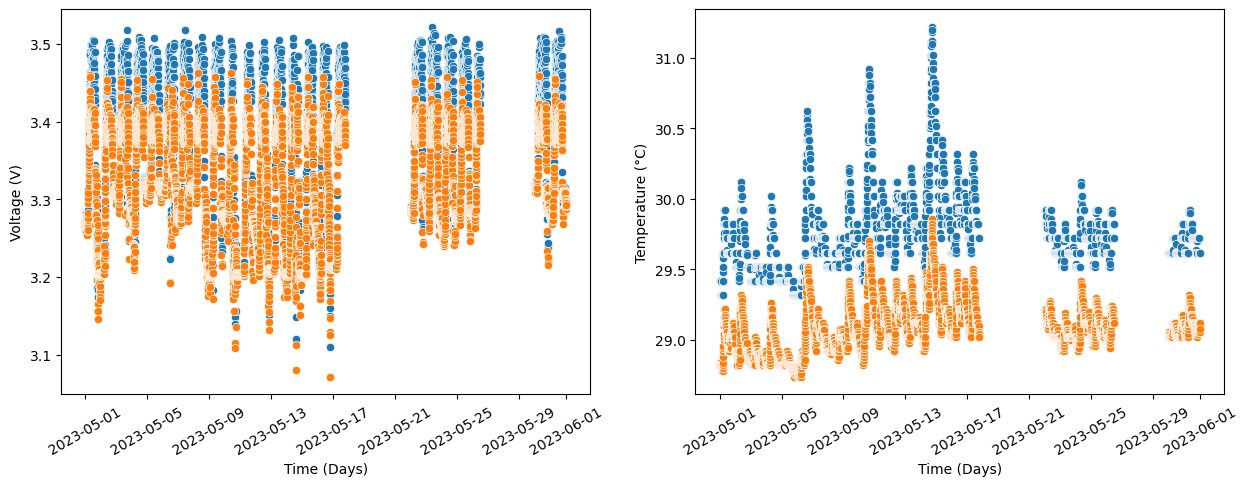

In [21]:
dataset_2 = dataset_2[dataset_2["temperature_cell_max"]>28] #Handling outliers
dataset_2 = dataset_2[dataset_2["temperature_cell_min"]>28]
dataset_2 = dataset_2[dataset_2["voltage_cell_max"]>3]
dataset_2 = dataset_2[dataset_2["voltage_cell_min"]>3]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=dataset_2, x=dataset_2.index, y="voltage_cell_max")
sns.scatterplot(data=dataset_2, x=dataset_2.index, y="voltage_cell_min")
plt.ylabel("Voltage (V)")
plt.xlabel("Time (Days)")
plt.xticks(rotation=30)

plt.subplot(1, 2, 2)
sns.scatterplot(data=dataset_2, x=dataset_2.index, y="temperature_cell_max")
sns.scatterplot(data=dataset_2, x=dataset_2.index, y="temperature_cell_min")
plt.ylabel("Temperature (°C)")
plt.xlabel("Time (Days)")
plt.xticks(rotation=30)
plt.show

The voltage of these cells ranges between 3.0 and 3.6 V approximately, while the temperature stays between 28.5 and 31.5 °C. The narrow voltage range indicates that the type of cell chemistry used is LFP, which is primarily used for energy storage, further confirming the assumption from earlier. Finally, to verify the proposition, we plot the voltage for the complete system.

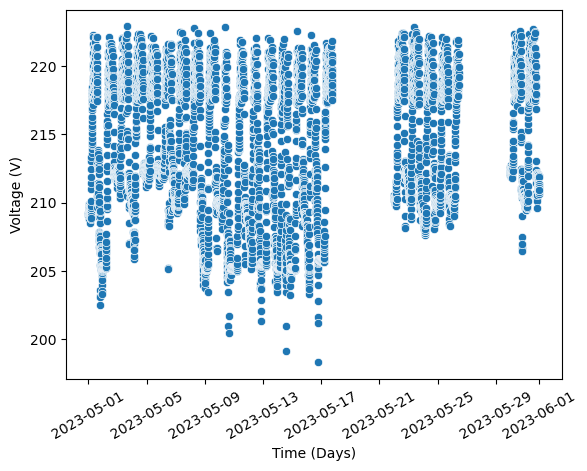

In [22]:
dataset_2 = dataset_2[dataset_2["voltage"]>195] #Handling outliers

sns.scatterplot(data=dataset_2, x=dataset_2.index, y="voltage")
plt.ylabel("Voltage (V)")
plt.xlabel("Time (Days)")
plt.xticks(rotation=30)
plt.show()

As expected from a LFP battery, its voltage (as well as its capacity of 3.4 Ah per cell and 27.2 Ah for the system) is lower than that of the previous dataset (NMC). This kind of battery could be used for home energy storage, such as for energy obtained from locally-installed solar panels.

For the number of cells, the same operation as for the previous dataset gives that there are 8 cells connected in each module, also in parallel. As before:

In [23]:
number_of_cells(8, dataset_2)

510.30296835850964

There are roughly 510 single battery cells in this system (504 being the lower multiple of 8).

## Sample Dataset 3

Finally, Dataset 3 contains 10079 data points obtained from September 14th to 21st, 2021, with observations extracted once every minute.

The variable *dataset_3* is created and the current is plotted.

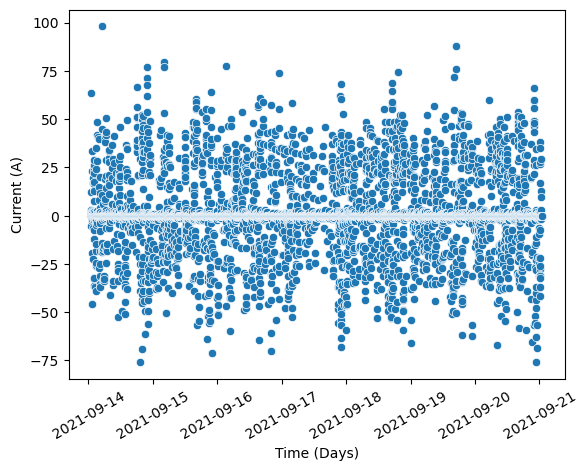

In [24]:
dataset_3 = csv_to_pd("data//sample_dataset_3.csv")

plot_current(dataset_3)

Unlike the first two datasets, where the currents appeared to follow a pattern of ascending and descending, this one shows no (visible) sequence. Since there are no considerable gaps like in Dataset 2, the *count_na()* function is used to get an idea of how many missing values we are dealing with.

In [25]:
count_na(dataset_3["current"])

'There are 0 NA instances, which represent 0.0% of the variable.'

This is fortunate, since it wouldn't be wise to use the *missing_current()* function for less ordered elements. We can move on with the modes classification.

In [26]:
modes_count_3 = charging_modes(dataset_3, threshold=0.5)
print(modes_count_3)

{'Charging': 1846, 'Discharging': 1608, 'Idle': 6625}


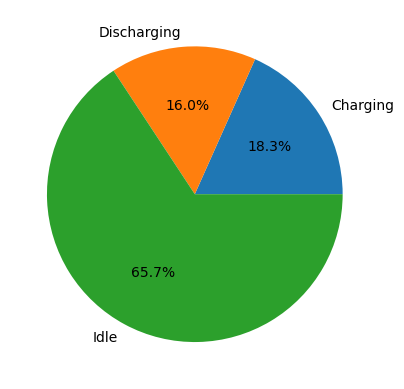

In [27]:
plot_piechart(modes_count_3)

Once again, we encounter the idle state as the predominant one. This would suggest that the battery is also used for storage purposes, and perhaps also of LFP cell chemistry. We will now the voltage and temperatures for individual cells to evaluate these claims.

<function matplotlib.pyplot.show(close=None, block=None)>

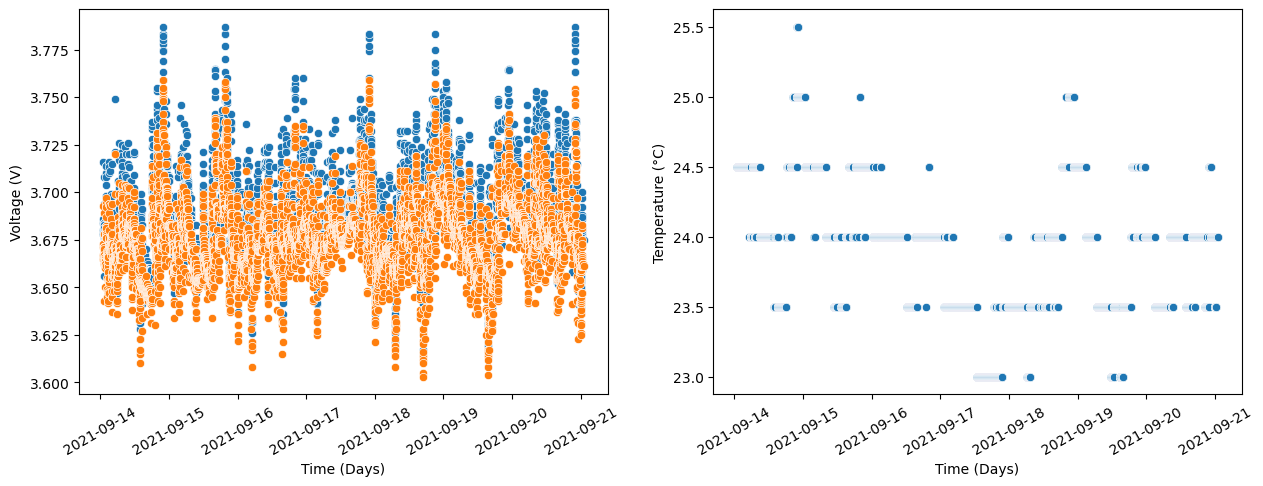

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=dataset_3, x=dataset_3.index, y="voltage_cell_max")
sns.scatterplot(data=dataset_3, x=dataset_3.index, y="voltage_cell_min")
plt.ylabel("Voltage (V)")
plt.xlabel("Time (Days)")
plt.xticks(rotation=30)

plt.subplot(1, 2, 2)
sns.scatterplot(data=dataset_3, x=dataset_3.index, y="temperature")
plt.ylabel("Temperature (°C)")
plt.xlabel("Time (Days)")
plt.xticks(rotation=30)
plt.show

The voltage range (~3.6-3.8 V) for this dataset is completely outside the range of Dataset 2 (~3.0-3.6 V), which disproves that the cell chemistry used for this battery is LFP. Instead, the voltage values may imply that the battery type is NCA. Hence, the full voltage of the system will be displayed to look further into this.

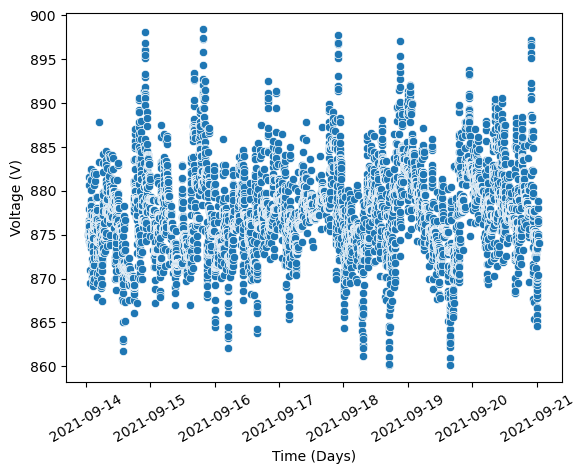

In [29]:
sns.scatterplot(data=dataset_3, x=dataset_3.index, y="voltage")
plt.ylabel("Voltage (V)")
plt.xlabel("Time (Days)")
plt.xticks(rotation=30)
plt.show()

The voltage here is higher than for the first battery (~680 V) and for the second battery (~223 V), so it is assumed that it is used for high-energy distribution. This is complemented by the high individual cell capacity of 63 Ah and by the system's 126 Ah. Since it was established from the beginning that the idle state was predominant, this battery could be used for high-energy storage systems, which is also a known application of NCA batteries.

Each module of this system is composed of 2 cells, and for the total number:

In [30]:
number_of_cells(2, dataset_3)

475.55807942542407

There are approximately 476 single cells in this system.